# Project Goal
In this project, I build a deep neural network that functions as part of a neural machine translation pipeline. The pipeline accepts English text as input and returns the French translation. The goal is to achieve the highest translation accuracy possible.

**Approach for This Project**
To translate a corpus of English text to French, we need to build a recurrent neural network (RNN). Before diving into the implementation, let’s first build some intuition of RNNs and why they’re useful for NLP tasks.

# RNN
RNNs are designed to take sequences of text as inputs or return sequences of text as outputs, or both.

They’re called recurrent because the network’s hidden layers have a loop in which the output and cell state from each time step become inputs at the next time step. This recurrence serves as a form of memory.

It allows contextual information to flow through the network so that relevant outputs from previous time steps can be applied to network operations at the current time step.

# RNN Setup

Depending on the use-case, we’ll want to set up our RNN to handle inputs and outputs differently. For this project, we’ll use a many-to-many process where the input is a sequence of English words and the output is a sequence of French words.

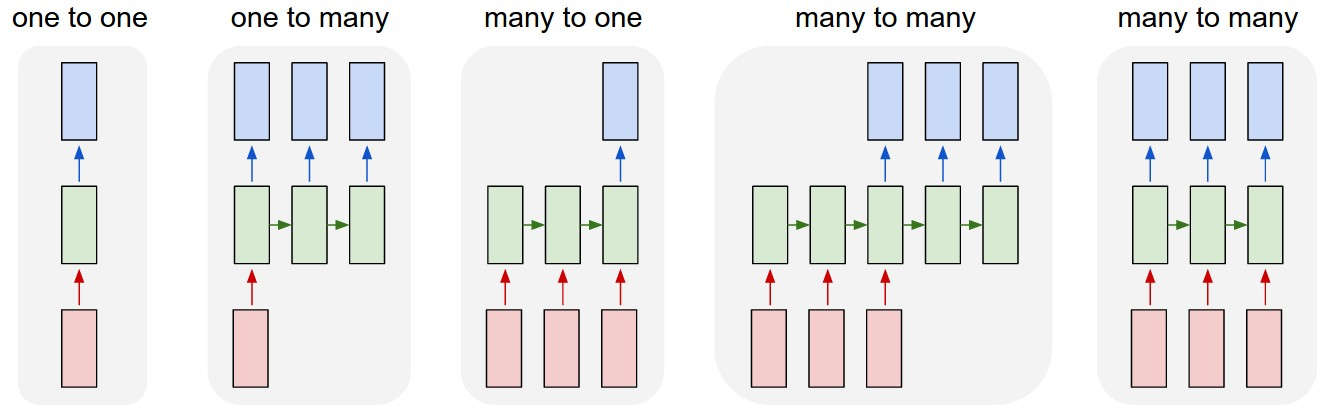


# Building the Pipeline
Below is a summary of the various preprocessing and modeling steps.
The high-level steps include:

- Preprocessing: load and examine data, cleaning, tokenization, padding
- Modeling: build, train, and test the model
- Prediction: generate specific translations of English to French, and compare the output translations to the ground truth translations
- Iteration: iterate on the model, experimenting with different architectures

**Deep learning Frameworks**
We use Keras for the frontend and TensorFlow for the backend in this project.

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import array, argmax, random, take
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
# For GPU

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# Data Load & Examine Data

**About Dataset**

French/English parallel texts for training translation models. Over 22.5 million sentences in French and English. Dataset created by Chris Callison-Burch, who crawled millions of web pages and then used a set of simple heuristics to transform French URLs onto English URLs, and assumed that these documents are translations of each other.

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

--2023-11-08 21:29:07--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  32.9MB/s    in 0.2s    

2023-11-08 21:29:07 (32.9 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


# Data Preprocessing

In [ ]:
# To convert our dataset into TensorFlow dataset types for easy manipulation,
# the model have used tensorflow Text_Line_Dataset class.

text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
# To calculate sequence length
# for seq in text_dataset.skip(190000):
#   print(len(tf.strings.split(seq," ")))

In [ ]:
# Config vocab
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

Now, here we construct model Vectorization layer for both English and French.

where, the model has used tensorflow tf.keras.layers.TextVectorization()
which is a preprocessing layer which maps text features to integer sequences.
It transforms a batch of strings into either a list of token indices  or a dense representation.
The processing of each example contains the following steps:

- Standardize each example (usually lowercasing + punctuation stripping) :

  "lower_and_strip_punctuation": Text will be lowercased and all punctuation removed.
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index, either into a vector of ints or a dense float vector.

In [ ]:
# Vectorization layer for English.

english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,                       # Maximum size of the vocabulary for this layer.
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
# Vectorization layer for French.

french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
# so the idea is, we wanna create corresponding translation of each English word to French word.
# Here, selector method will spilt English text and French text using index slicing.

def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

split_dataset=text_dataset.map(selector)

In [ ]:
# Lets, examine selector method()
for i in split_dataset.take(5):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'star

In [ ]:
# separator method(), will take input similar to selector, but the difference
# English word is X[0:1] and y French word, where y is the combination of the ['start']+ input [1:2] + ['end'], so that we have both the tokens taken into consideration.

def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

init_dataset=text_dataset.map(separator)

In [ ]:
# check separator() on init_dataset.
for i in init_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va ! endtoken'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche. endtoken'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route ! endtoken'], dtype=object)>)


In [ ]:
# Now, here we build and adapt our both English and French vectorize_layer with training data.

# input x,y and output x, where x is English and y is French and we want output English (x)
english_training_data=init_dataset.map(lambda x,y:x)

# adapt the vectorize_layer to the training data
english_vectorize_layer.adapt(english_training_data)

In [ ]:
#input x,y and output y, where x is English and y is French and we want output French (y)
french_training_data=init_dataset.map(lambda x,y:y)

# adapt the vectorize_layer to the training data
french_vectorize_layer.adapt(french_training_data)

In [ ]:
# Here, this method will vectorizer our dataset.
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),                                     # input
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)       # output

In [ ]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
# let's check 1 sample from vectorized dataset
for i in split_dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)


In [ ]:
# What does the above matrix mean
english_vectorize_layer.get_vocabulary()[43]

'his'

In [ ]:
# compare with french_word
french_vectorize_layer.get_vocabulary()[43]

'veux'

In [ ]:
# So, now we have achived our desired dataset, we will use this dataset for model tranining.
# here, data will be shuffled and used prefetching, such that we could carry out traning much more efficiently.
# And then we are batching our data.
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# NUM_BATCHES = total number of elements/batch size, which is 64.

NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
# Split the data into train and validation set.

train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# The encoder & Decoder

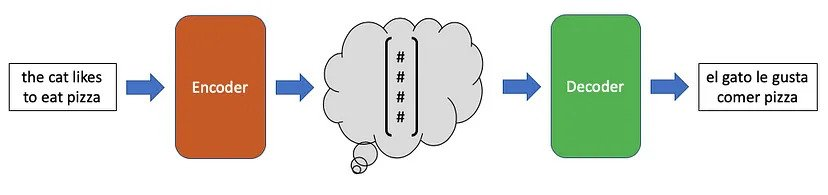

Our sequence-to-sequence model links two recurrent networks: an encoder and decoder. The encoder summarizes the input into a context variable, also called the state. This context is then decoded and the output sequence is generated.

Since both the encoder and decoder are recurrent, they have loops which process each part of the sequence at different time steps. To picture this, it’s best to unroll the network so we can see what’s happening at each time step.

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

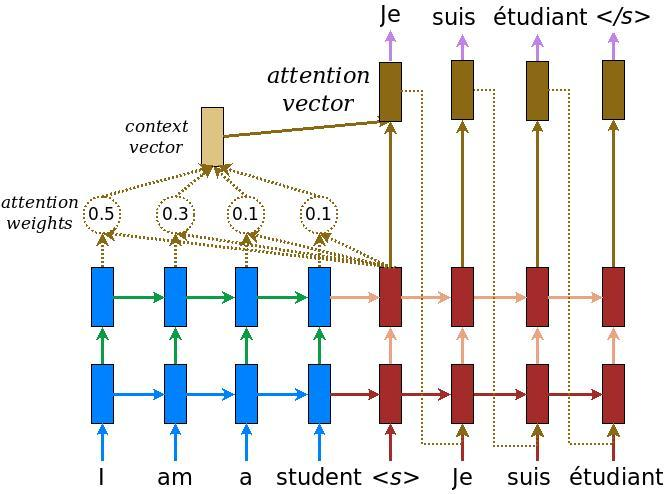


# The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing.


# The attention/decoder layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.



# Modeling
**Bidirectional GRU model**

In [ ]:
NUM_UNITS=256

### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

# BLEU score for evaluating machine-translated text:

- The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations.

- A value of 0 means that the machine-translated output has no overlap with the reference translation (low quality) while a value of 1 means there is perfect overlap with the reference translations (high quality).

- It is calculated by comparing the n-grams of machine-translated sentences to the n-gram of human-translated sentences. Usually, it has been observed that the BLEU score decreases as the sentence length increases. This, however, might vary depending upon the model used for translation.


**Interpretation:**

Trying to compare BLEU scores across different corpora and languages is strongly discouraged. Even comparing BLEU scores for the same corpus but with different numbers of reference translations can be highly misleading.

However, as a rough guideline, the following interpretation of BLEU scores:
BLEU Score	Interpretation

< 10	Almost useless

10 - 19	Hard to get the gist

20 - 29	The gist is clear, but has significant grammatical errors

30 - 40	Understandable to good translations

40 - 50	High quality translations

50 - 60	Very high quality, adequate, and fluent translations

greater than 60	Quality often better than human

Mathematically, the BLEU score is defined as:

The formula consists of two parts: the brevity penalty and the n-gram overlap.
1. Brevity Penalty
The brevity penalty penalizes generated translations that are too short compared to the closest reference length with an exponential decay. The brevity penalty compensates for the fact that the BLEU score has no recall term.

2. N-Gram Overlap
The n-gram overlap counts how many unigrams, bigrams, trigrams, and four-grams (i=1,...,4) match their n-gram counterpart in the reference translations.

bleu score math.png

Here,

BP stands for Brevity Penalty, which penalizes the score when the Machine Translation is too short compared to the Reference (Correct) translations.

n ∈ [1,4]

Pn is the n-gram modified precision score.

In [ ]:
# custom BLEU score class
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

# Loss function Sparse Categorical Cross entropy:

Computes the crossentropy loss between the labels and predictions.

The reason why we use this Sparse Categorical Cross entropy loss and not Categorical Cross entropy loss itself is simply, because the way our model or the way our dataset was created was constructed.

What this means is, if our output are not One-hot-representaions then in that case, we use SparseCategoricalCrossentropy() loss.

In [ ]:
with tf.device(device_name):
  seq2seq_gru.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(5e-4),)
    #metrics=[BLEU()],
    #run_eagerly=True)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [ ]:
with tf.device(device_name):
  history=seq2seq_gru.fit(
      train_dataset,
      validation_data=val_dataset,
      epochs=10,
      callbacks=[model_checkpoint_callback])

Epoch 1/10
   2812/Unknown - 369s 127ms/step - loss: 0.4637

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2812/2812 [==============================] - 439s 152ms/step - loss: 0.4637 - val_loss: 0.7198
Epoch 2/10
2812/2812 [==============================] - 411s 146ms/step - loss: 0.2716 - val_loss: 0.6301
Epoch 3/10
2812/2812 [==============================] - 410s 146ms/step - loss: 0.2127 - val_loss: 0.5851
Epoch 4/10
2812/2812 [==============================] - 408s 145ms/step - loss: 0.1774 - val_loss: 0.5604
Epoch 5/10
2812/2812 [==============================] - 409s 145ms/step - loss: 0.1540 - val_loss: 0.5509
Epoch 6/10
2812/2812 [==============================] - 405s 144ms/step - loss: 0.1371 - val_loss: 0.5362
Epoch 7/10
2812/2812 [==============================] - 398s 141ms/step - loss: 0.1246 - val_loss: 0.5460
Epoch 8/10
2812/2812 [==============================] - 404s 144ms/step - loss: 0.1145 - val_loss: 0.5549
Epoch 9/10
2812/2812 [==============================] - 403s 143ms/step - loss: 0.1064 - val_loss: 0.5457
Epoch 10/10
2812/2812 [==============================] - 

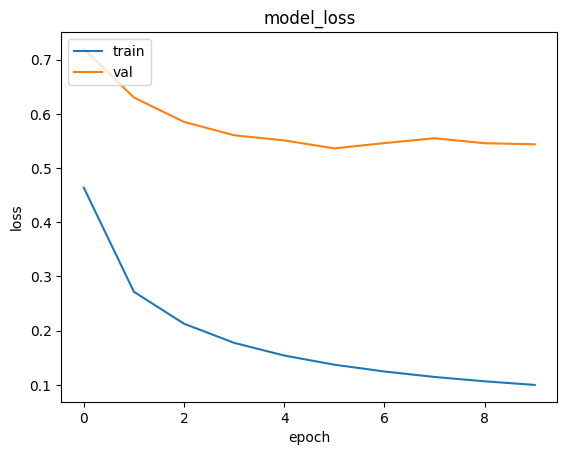

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model_accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Evaluation

In [ ]:
with tf.device(device_name):
  seq2seq_gru.evaluate(val_dataset)

748/748 [==============================] - 63s 47ms/step - loss: 0.5439


# Testing

In [ ]:
# Here, we are creating index to word dictionary, in such a way that, we go through the range of values between zero and length of vocabulary - 1.
# So, we will have key-value pairs, index and the corresponding word.

index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

print(index_to_word)

{0: '', 1: '[UNK]', 2: 'starttoken', 3: 'endtoken', 4: 'je', 5: 'de', 6: 'pas', 7: 'que', 8: 'ne', 9: 'le', 10: 'à', 11: 'la', 12: 'vous', 13: 'tom', 14: 'il', 15: 'est', 16: 'tu', 17: 'un', 18: 'ce', 19: 'a', 20: 'nous', 21: 'les', 22: 'une', 23: 'en', 24: 'jai', 25: 'suis', 26: 'pour', 27: 'me', 28: 'faire', 29: 'cest', 30: 'dans', 31: 'plus', 32: 'des', 33: 'elle', 34: 'ça', 35: 'tout', 36: 'qui', 37: 'te', 38: 'fait', 39: 'ma', 40: 'du', 41: 'mon', 42: 'avec', 43: 'veux', 44: 'se', 45: 'au', 46: 'si', 47: 'et', 48: 'cette', 49: 'sont', 50: 'y', 51: 'quil', 52: 'très', 53: 'pense', 54: 'cela', 55: 'nest', 56: 'son', 57: 'sur', 58: 'votre', 59: 'pourquoi', 60: 'dit', 61: 'temps', 62: 'sais', 63: 'être', 64: 'été', 65: 'était', 66: 'peux', 67: 'moi', 68: 'nai', 69: 'chose', 70: 'ici', 71: 'jamais', 72: 'ils', 73: 'lui', 74: 'comment', 75: 'où', 76: 'bien', 77: 'estce', 78: 'ton', 79: 'quelque', 80: 'vraiment', 81: 'beaucoup', 82: 'on', 83: 'besoin', 84: 'dire', 85: 'tous', 86: 'toi', 

In [ ]:
# Here, translator() method, which takes in the English sentence and returns French sentence.

def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  # Now, in this loop once we get first output, we are going to pass that in, repeat that right up to end.
  # Loop will only stop, if we find the end token.
  # so, FRENCH_SEQUENCE_LENGTH = 64

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])

    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    # Here, the output will in the One-hot-representaions, so to get the position of the highest or the position with the highest score, we should use max().

    #argmax() to get positions of the highest probabilities.
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()

    # use index_to_word to obtain current word
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that is not true?')

1/1 [==============================] - 0s 22ms/step


'questce qui te fait penser que ce nest pas vrai'

In [ ]:
translator("hello beautiful")

1/1 [==============================] - 0s 66ms/step


'bonjour à la musique'

In [ ]:
translator('we need to train on more data to get better results')

1/1 [==============================] - 0s 24ms/step


'nous devons nous faire du plus grand tous les règles'

In [ ]:
# map word to index
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}
print(word_to_index)

{'': 0, '[UNK]': 1, 'starttoken': 2, 'endtoken': 3, 'je': 4, 'de': 5, 'pas': 6, 'que': 7, 'ne': 8, 'le': 9, 'à': 10, 'la': 11, 'vous': 12, 'tom': 13, 'il': 14, 'est': 15, 'tu': 16, 'un': 17, 'ce': 18, 'a': 19, 'nous': 20, 'les': 21, 'une': 22, 'en': 23, 'jai': 24, 'suis': 25, 'pour': 26, 'me': 27, 'faire': 28, 'cest': 29, 'dans': 30, 'plus': 31, 'des': 32, 'elle': 33, 'ça': 34, 'tout': 35, 'qui': 36, 'te': 37, 'fait': 38, 'ma': 39, 'du': 40, 'mon': 41, 'avec': 42, 'veux': 43, 'se': 44, 'au': 45, 'si': 46, 'et': 47, 'cette': 48, 'sont': 49, 'y': 50, 'quil': 51, 'très': 52, 'pense': 53, 'cela': 54, 'nest': 55, 'son': 56, 'sur': 57, 'votre': 58, 'pourquoi': 59, 'dit': 60, 'temps': 61, 'sais': 62, 'être': 63, 'été': 64, 'était': 65, 'peux': 66, 'moi': 67, 'nai': 68, 'chose': 69, 'ici': 70, 'jamais': 71, 'ils': 72, 'lui': 73, 'comment': 74, 'où': 75, 'bien': 76, 'estce': 77, 'ton': 78, 'quelque': 79, 'vraiment': 80, 'beaucoup': 81, 'on': 82, 'besoin': 83, 'dire': 84, 'tous': 85, 'toi': 86, 